In [101]:
import numpy as np
from numpy import exp
from numpy.random import randn
from scipy.optimize import fminbound, brentq
import matplotlib.pyplot as plt
import quantecon as qe

In [124]:
Π = ((0.98, 0.02), (0.5, 0.5))
σ_vals = (0.2, 0.8)
mc = qe.MarkovChain(Π, σ_vals)

In [125]:
σ_mean = mc.simulate(100000).mean()
μ = - σ_mean**2 / 2 

In [126]:
σ_mean

0.22343000000000005

average returns

In [127]:
np.mean(exp(μ + σ_mean * randn(10000)))

0.9979477998938008

In [128]:
0.96 * _

0.9580298878980487

Labor income vals, with 50/50 probability, iid:

In [129]:
y_vals = (0.5, 1.5)

In [130]:
class ConsumerProblem:

    def __init__(self, 
                 r=0.01, 
                 β=0.96, 
                 Y=1.0,
                 μ=μ,
                 Π=Π,
                 σ_vals=σ_vals, 
                 y_vals=y_vals,
                 grid_max=5, 
                 grid_size=50,
                 du=lambda x: x**(-1.5),
                 sv=True):

        self.du = du
        self.r, self.R = r, 1 + r
        self.β = β
        self.y_vals = y_vals
        self.Π, self.σ_vals = np.array(Π), tuple(σ_vals)
        
        self.mc = qe.MarkovChain(Π, σ_vals)
        self.μ = μ
        
        self.asset_grid = np.linspace(1e-8, grid_max, grid_size)
        
        self.ζ = np.random.randn(1000)

In [131]:
def coleman_operator(c, cp):
    """
    The approximate Coleman operator.

    Parameters
    ----------
    c : array_like(float)
        A NumPy array of dim len(cp.asset_grid) times len(cp.z_vals)
    cp : ConsumerProblem
        An instance of ConsumerProblem that stores primitives

    Returns
    -------
    array_like(float)
        The updated policy.

    """
    # === simplify names, set up arrays === #
    R, Π, β, du, μ, ζ = cp.R, cp.Π, cp.β, cp.du, cp.μ, cp.ζ
    y0, y1 = cp.y_vals
    asset_grid, σ_vals = cp.asset_grid, cp.σ_vals
    σ_l, σ_h = σ_vals
    
    R_l = exp(μ + σ_l * ζ)
    R_h = exp(μ + σ_h * ζ)

    # == allocate memory == #
    Kc = np.empty(c.shape)
    
    # == interpolate, one function for each σ value == #
    cf_l = lambda x: np.interp(x, asset_grid, c[:, 0])
    cf_h = lambda x: np.interp(x, asset_grid, c[:, 1])

    # === solve for root to get Kc === #
    for i_a, a in enumerate(asset_grid):
        for i_σ, σ in enumerate(σ_vals):
            def h(t):
                p = du(cf_l(R_l * (a - t) + y0)) * 0.5
                q = du(cf_l(R_l * (a - t) + y1)) * 0.5
                e1 = R_l * (p + q) * Π[i_σ, 0] 
                
                p = du(cf_h(R_h * (a - t) + y0)) * 0.5
                q = du(cf_h(R_h * (a - t) + y1)) * 0.5
                e2 = R_h * (p + q) * Π[i_σ, 1] 
                
                expectation = β * np.mean(e1 + e2)
                return du(t) - max(expectation, du(a))
            Kc[i_a, i_σ] = brentq(h, 1e-8, a)

    return Kc

In [132]:
def initialize(cp):
    """
    Creates a suitable initial conditions V and c for value function and time
    iteration respectively.

    """
    # === Simplify names, set up arrays === #
    R, β = cp.R, cp.β
    asset_grid, σ_vals = cp.asset_grid, cp.σ_vals
    
    shape = len(asset_grid), len(σ_vals)
    c = np.empty(shape)

    # === Populate V and c === #
    for i_a, a in enumerate(asset_grid):
        for i_σ, σ in enumerate(σ_vals):
            c_max = a
            c[i_a, i_σ] = c_max

    return c

In [133]:
def compute_consumption_function(cp):
 
    # == compute the consumption function == #
    c_init = initialize(cp)
    K = lambda c: coleman_operator(c, cp)
    c = qe.compute_fixed_point(K, c_init, verbose=2, print_skip=20, max_iter=1000)

    # == turn it into a true function
    cf = lambda a, i_σ: np.interp(a, cp.asset_grid, c[:, i_σ])
    return cf
    

In [134]:
def gen_policy_plot(cp, cf):
    a_grid = cp.asset_grid
    
    fig, ax = plt.subplots(figsize=(8, 5.5))
    ax.plot(a_grid, cf(a_grid, 0), label="low sigma")
    ax.plot(a_grid, cf(a_grid, 1), label="high sigma")
    ax.plot(a_grid, a_grid, 'k--')
    ax.set(xlabel='assets', ylabel='consumption',
           xlim=(0, 4), ylim=(0, 4))
    ax.legend()
    plt.show()

First a model with stochastic volatility:

In [135]:
cp_sv = ConsumerProblem()
cf_sv = compute_consumption_function(cp_sv)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
20           4.346e-03      7.083e+00         
30           8.602e-04      1.073e+01         
Converged in 30 steps


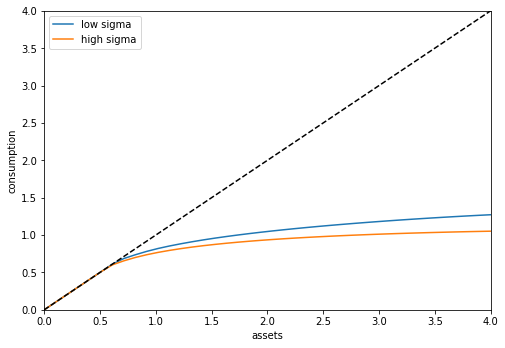

In [136]:
gen_policy_plot(cp_sv, cf_sv)

In [137]:
cp_nsv = ConsumerProblem(σ_vals=(σ_mean, σ_mean))
cf_nsv = compute_consumption_function(cp_nsv)

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
20           1.179e-03      6.634e+00         
21           8.918e-04      6.974e+00         
Converged in 21 steps


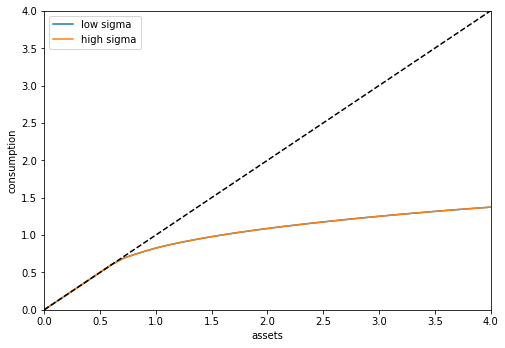

In [138]:
gen_policy_plot(cp_nsv, cf_nsv)

In [139]:
def generate_state_path(cp, cf=None, T=10000):
    
    # == get consumption function == #
    if cf is None:
        cf = compute_consumption_function(cp)
    
    # == simplify names == #
    Π, σ_vals, R, μ = cp.Π, cp.σ_vals, cp.R, cp.μ  
    y_vals = cp.y_vals
    mc = cp.mc
    
    a = np.zeros(T)
    a[0] = np.mean(y_vals)
    R = np.zeros(T-1)
    σ_seq = mc.simulate_indices(T)

    for t in range(T-1):
        i_σ = σ_seq[t+1]
        σ = σ_vals[i_σ] 
        R[t] = exp(μ + σ * randn())
        Y = y_vals[np.random.randint(0, 2)]
        a[t+1] =  R[t] * (a[t]  - cf(a[t], i_σ)) + Y
        
    return a, R

In [152]:
a_sv, R_sv = generate_state_path(cp_sv, cf=cf_sv)

In [153]:
a_nsv, R_nsv = generate_state_path(cp_nsv, cf=cf_nsv)

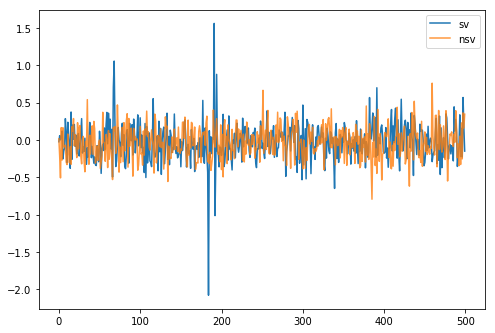

In [154]:
R_sv = R_sv[:500]
R_nsv = R_nsv[:500]
fig, ax = plt.subplots(figsize=(8, 5.5))
ax.plot(np.arange(len(R_sv)), np.log(R_sv), label='sv')
ax.plot(np.arange(len(R_nsv)), np.log(R_nsv), label='nsv', alpha=0.8)

ax.legend()
plt.show()

In [155]:
np.std(R_sv), np.std(R_nsv)

(0.2992551773451794, 0.22110800008011655)

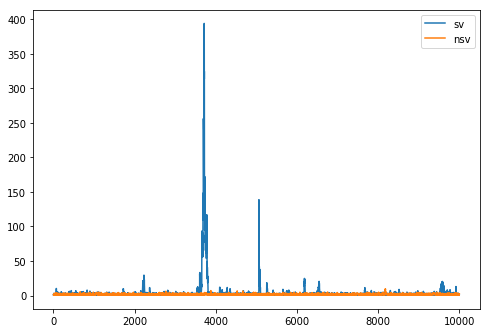

In [156]:
fig, ax = plt.subplots(figsize=(8, 5.5))
ax.plot(np.arange(len(a_sv)), a_sv, label='sv')
ax.plot(np.arange(len(a_nsv)), a_nsv, label='nsv')

ax.legend()
plt.show()

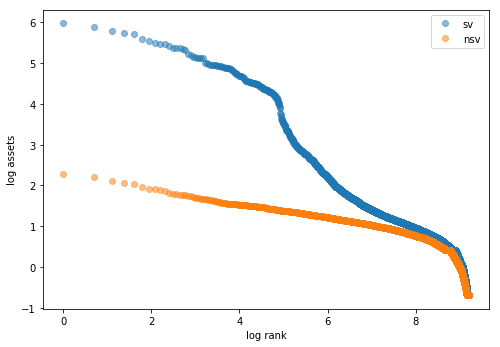

In [157]:
fig, ax = plt.subplots(figsize=(8, 5.5))

for a_vec, label in zip((a_sv, a_nsv), ('sv', 'nsv')):

    a_vec = - np.sort(- a_vec) # Reverse sort
    xdata = np.log(np.arange(len(a_vec)) + 1)
    ydata = np.log(a_vec)
    ax.plot(xdata, ydata, 'o', alpha=0.5, label=label)

ax.set_xlabel("log rank")
ax.set_ylabel("log assets")

ax.legend()

plt.show()